In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

import sys
sys.path.append('../')
from src.models.agg_catboost import agg_catboost

import os
import warnings
warnings.filterwarnings("ignore") 

from datetime import datetime
from IPython.display import display, Markdown

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
collisions_df = pd.read_csv('../data/Collisions.csv',
                            parse_dates={'Datetime': ['INCDTTM']}, 
                            infer_datetime_format=True)
streets_df = pd.read_csv('../data/Seattle_Streets.csv')

In [3]:
def load_unique(df, yr):
    out = pd.DataFrame(df.groupby('STNAME')['AAWDT'].mean())
    out['YEAR'] = int(yr)
    return out
#These important names have changed over the years
def name_check(lst):
    if 'STNAME' in lst:
        return 'STNAME'
    elif 'FIRST_STNAME_ORD' in lst:
        return 'FIRST_STNAME_ORD'
    else:
        return 'STNAME_ORD'

def metric_check(lst):
    if 'AAWDT' in lst:
        return 'AAWDT'
    elif 'COUNTAAWDT' in lst:
        return 'COUNTAAWDT'
    else:
        return 'AWDT'

In [4]:
folder = '../data/counts/'
traffic_df = pd.read_csv('../data/counts/2007_Traffic_Flow_Counts.csv')[['STNAME', 'AAWDT']]
traffic_df = load_unique(traffic_df, '2007')

for f in sorted(os.listdir(folder))[1:]:
    file = folder + f
    d = pd.read_csv(file)

    name_column, metric_column = name_check(d.columns), metric_check(d.columns)
    d.rename(columns={name_column:'STNAME', metric_column:'AAWDT'}, inplace=True)
    d = d[['STNAME', 'AAWDT']]
    d = load_unique(d, f[:4])
    
    #we'll only take the columns we can consistently use for now
    traffic_df = traffic_df[traffic_df.index.isin(d.index)]
    d = d[d.index.isin(traffic_df.index)] 
    
    traffic_df = pd.concat([traffic_df, d], sort=False)
    
traffic_df = traffic_df[~traffic_df.duplicated()]

In [5]:
block_mask = collisions_df['ADDRTYPE'] == 'Block'

collision_streets = pd.DataFrame(collisions_df[block_mask]['LOCATION'].apply(lambda string: string.split(' BETWEEN ')[0]))

collision_streets['datetime'] = collisions_df[block_mask]['Datetime']

In [6]:
collisions_by_year = collision_streets.groupby(pd.Grouper(key='datetime', freq='Y'))['LOCATION'].value_counts().unstack(level=0).fillna(0)

for column in collisions_by_year.columns:
    collisions_by_year.rename(columns={column:column.year}, inplace=True)
    
collisions_by_year.drop(columns=[2004,2005,2006,2019,2020], inplace=True)

In [7]:
streets_df = streets_df[streets_df['STATUS'] == 'INSVC']
sg = streets_df.groupby('STNAME_ORD')
d = {}
d['arterial_class'] = sg['ARTCLASS'].median().fillna(0).astype(int)
d['speed_limit'] =  sg['SPEEDLIMIT'].median().fillna(0).astype(int)
d['slope_percentage'] = sg['SLOPE_PCT'].median()
d['transit_class'] = sg['TRANCLASS'].median().astype(int)
d['pavement_condition'] = sg['PVMTCONDINDX1'].median()
columns = ['ARTCLASS', 'SPEEDLIMIT', 'SLOPE_PCT', 'TRANCLASS', 'PVMTCONDINDX']
clean_streets = pd.DataFrame(data=d)
clean_streets = clean_streets[clean_streets.index.isin(collisions_by_year.index)]

In [8]:
traffic_df['collisions'] = 0
for st in collisions_by_year.index:
    for year in collisions_by_year.columns:
        try:
            traffic_df['collisions'].loc[(traffic_df.index==st) & (traffic_df['YEAR'] == year)] = collisions_by_year.loc[st][year]
        except:
            pass

In [9]:
for variable in clean_streets.columns:
    traffic_df[variable] = 0
for st in traffic_df.index:
    for variable in clean_streets.columns:
        try:
            traffic_df[variable].loc[st] = clean_streets[variable].loc[st]
        except:
            pass

In [10]:
model_df = traffic_df.copy()
y = model_df.pop('collisions')

In [11]:
model_df.drop(columns=['YEAR', 'pavement_condition'], inplace=True)

In [12]:
feats = ['arterial_class', 'speed_limit', 'transit_class']

clf = agg_catboost(model_df, y, feats)
clf.train_model()

'Training on 5 k-folds complete'

In [13]:
clf.print_metrics(round_=True)

base_mse: 1643.75, actual: 128.86 
 feature_importances: [25.07, 5.13, 25.94, 25.21, 18.66]

base_mse: 1392.292, actual: 199.37 
 feature_importances: [27.6, 4.14, 28.44, 22.96, 16.85]

base_mse: 1636.237, actual: 133.401 
 feature_importances: [24.91, 5.37, 26.46, 24.58, 18.67]

base_mse: 1299.644, actual: 109.79 
 feature_importances: [24.67, 4.99, 27.32, 23.78, 19.24]

base_mse: 1415.337, actual: 129.838 
 feature_importances: [24.86, 3.3, 27.12, 22.19, 22.53]



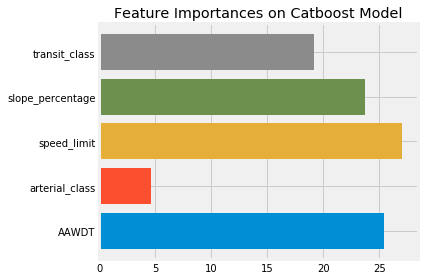

In [14]:
clf.plot_feature_importances()